# **0.Importamos las librerias**

In [ ]:
import pandas as pd
import numpy as np
#Viz
import matplotlib.pyplot as plt
import seaborn as sns
#Normalizacion
from sklearn.preprocessing import StandardScaler
#Modelos de clustering Kmeans
from sklearn.cluster import KMeans
#Instalacion de fuzzy, por si se necesita
!pip install scikit-fuzzy
import skfuzzy as fuzz
#Cluster jerarquico
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
#Metricas de evaluacion de clustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import pairwise_distances
#Montamos el drive
from google.colab import drive
drive.mount('/content/drive')
#PCA
from sklearn.decomposition import PCA
from datetime import date
import plotly.express as px

La data entregada esta a nivel de boleta y tiene los siguientes campos:
- InvoiceNo: Nro identificador de cada boleta
- InvoiceDate: Fecha de la boleta
- CustomerId: Nro identificador de cada usuario
- Quantity: Cantidad de unidades totales compradas
- price_total: Precio total de la boleta
- StockCode: Cantidad de unidades diferentes compradas

# **1.Leer el archivo Retail_Invoices.xlsx y realizar un análisis de calidad de datos, para definir la calidad de la data entregada considerando valores anómalos, valores faltantes, etc. Limpia lo que sea necesario y realiza un análisis exploratorio de los datos considerando gráficos de distribuciones y correlaciones entre estos.**

In [2]:
# Leemos el archivo excel
df = pd.read_excel(
    "/content/drive/My Drive/Colab Notebooks/Machine Learning/2.Aprendizaje supervisado y no supervisado Parte I/Desafio/Retail_Invoices.xlsx")
print(df.shape)  # 22190,6 - Revisamos las dimensiones del dataset
print("")
df.head()  # Visualizamos

(22190, 6)



,InvoiceNo,InvoiceDate,CustomerID,Quantity,price_total,StockCode
0,536365,2010-12-01,17850,40,139.12,7
1,536366,2010-12-01,17850,12,22.20,2
2,536367,2010-12-01,13047,83,278.73,12
3,536368,2010-12-01,13047,15,70.05,4
4,536369,2010-12-01,13047,3,17.85,1


In [3]:
# Realizamos un rename de las columnas para que sea más facil la compresión de que significan los valores de cada columna de manera más rápida.
df = df.rename(columns={'InvoiceNo': 'ticket_id', 'InvoiceDate': 'ticket_date', 'CustomerID': 'customer_id',
               'Quantity': 'quantity', 'price_total': 'price_total', 'StockCode': 'different_units'})

In [4]:
df.info()  # Vemos los dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22190 entries, 0 to 22189
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ticket_id        22190 non-null  object        
 1   ticket_date      22190 non-null  datetime64[ns]
 2   customer_id      22190 non-null  int64         
 3   quantity         22190 non-null  int64         
 4   price_total      22190 non-null  float64       
 5   different_units  22190 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 1.0+ MB


In [5]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
ticket_date,22190,2011-06-29 05:59:15.223073536,2010-12-01 00:00:00,2011-03-29 00:00:00,2011-07-08 00:00:00,2011-10-10 00:00:00,2011-12-09 00:00:00,NaN
customer_id,22190.0,15238.498738,12346.0,13755.0,15136.0,16746.0,18287.0,1733.149624
quantity,22190.0,221.130599,-80995.0,30.0,120.0,254.0,80995.0,1170.215301
price_total,22190.0,374.045327,-168469.6,87.9625,241.505,418.0225,168469.6,2018.482869
different_units,22190.0,18.333889,1.0,3.0,12.0,24.0,542.0,23.892111


In [6]:
nulos = df.isnull().sum()  # Revision de nulos
print(f"La cantidad de nulos por columna en el dataset son: \n{nulos}")
print("")
dist_cust = df["customer_id"].nunique()  # La cantidad de compradores distintos
print(
    f"La cantidad de compradores distintos en el dataset son: \n{dist_cust} compradores")

La cantidad de nulos por columna en el dataset son: 
ticket_id          0
ticket_date        0
customer_id        0
quantity           0
price_total        0
different_units    0
dtype: int64

La cantidad de compradores distintos en el dataset son: 
4372 compradores


Creamos variables para hacer un analisis de distribución sobre las columnas numéricas

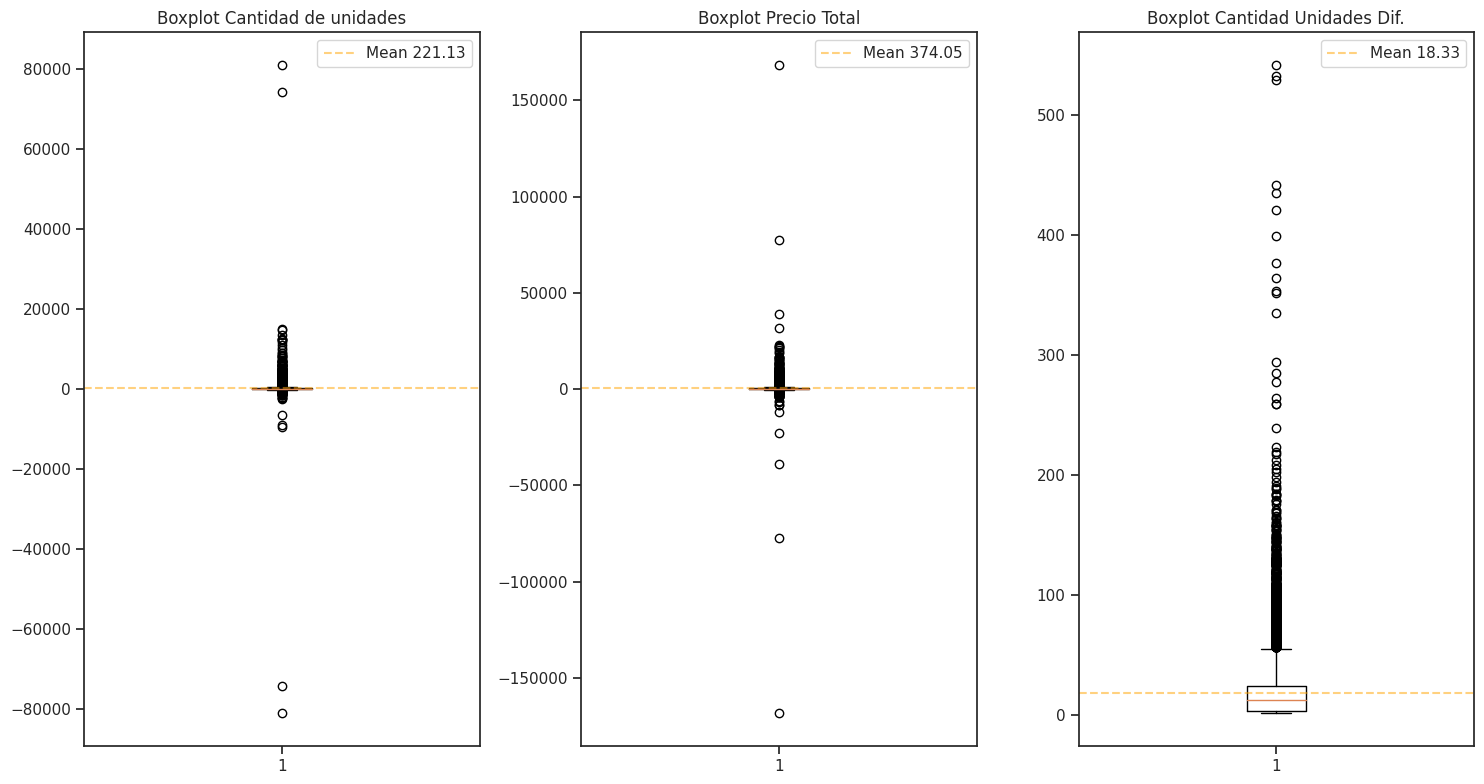

In [7]:
q = df["quantity"]
p_total = df["price_total"]
dif_units = df["different_units"]

# Visualizamos
sns.set_theme(style='ticks', palette='deep')
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 8))

# Boxplots
axs[0].boxplot(q)
axs[0].set_title("Boxplot Cantidad de unidades")
axs[0].axhline(q.mean(), linestyle="dashed", color="orange",
               alpha=0.5, label=f"Mean {round(q.mean(),2)}")
axs[0].legend()

axs[1].boxplot(p_total)
axs[1].set_title("Boxplot Precio Total")
axs[1].axhline(p_total.mean(), linestyle="dashed", color="orange",
               alpha=0.5, label=f"Mean {round(p_total.mean(),2)}")
axs[1].legend()

axs[2].boxplot(dif_units)
axs[2].set_title("Boxplot Cantidad Unidades Dif.")
axs[2].axhline(dif_units.mean(), linestyle="dashed", color="orange",
               alpha=0.5, label=f"Mean {round(dif_units.mean(),2)}")
axs[2].legend()

plt.tight_layout()
plt.legend()
plt.show()

In [8]:
q_range = q.max()-q.min()
p_range = p_total.max()-p_total.min()
dunits_range = dif_units.max()-dif_units.min()

print(f"Quantity STD:  {round(q.std(),2)}")
print(f"Price STD:  {round(p_total.std(),2)}")
print(f"Different Units STD:  {round(dif_units.std(),2)}")
print("")

print(f"Quantity Range:  {q_range}")
print(f"Price Range:  {p_range}")
print(f"Different Units Range:  {dunits_range}")

Quantity STD:  1170.22
Price STD:  2018.48
Different Units STD:  23.89

Quantity Range:  161990
Price Range:  336939.2
Different Units Range:  541


**Como podemos apreciar, las 3 columnas numéricas presentan bastantes outliers y además, los rangos de valores y desviación estandar entre cada una también son muy distintos según los contextos, por lo que necesitaremos estandarizarlas más adelante, para que el algoritmo de clustering trabaje de manera correcta.**

**Limpiaremos los outliers de las 3 colummnas**

In [9]:
# Filtramos el df ya que contenia valores de cantidad y precio menores que cero, los cuales no eran detectados por la funcion de limpieza de outliers a continuacion
df = df.loc[(df["price_total"] >= 0) & (df["quantity"] >= 0)]

In [10]:
columns_to_clean = ["quantity", "price_total", "different_units"]


def clean_outliers(df, columns):
    for column in columns:
        column = df[column]
        Q1 = np.percentile(column, 25)
        Q3 = np.percentile(column, 75)
        IQR = Q3-Q1
        LOWER = (Q1 - 1.5 * IQR)
        UPPER = (Q3 + 1.5 * IQR)

        df = df[(column >= LOWER) & (column <= UPPER)]
    return df


df_clean = clean_outliers(df, columns_to_clean)

print(
    f"Luego de la limpieza de outliers, el dataset pasó de {df.shape[0]} a tener {df_clean.shape[0]} registros  ")

Luego de la limpieza de outliers, el dataset pasó de 18536 a tener 15453 registros  


**Visualizaremos las columnas limpias**

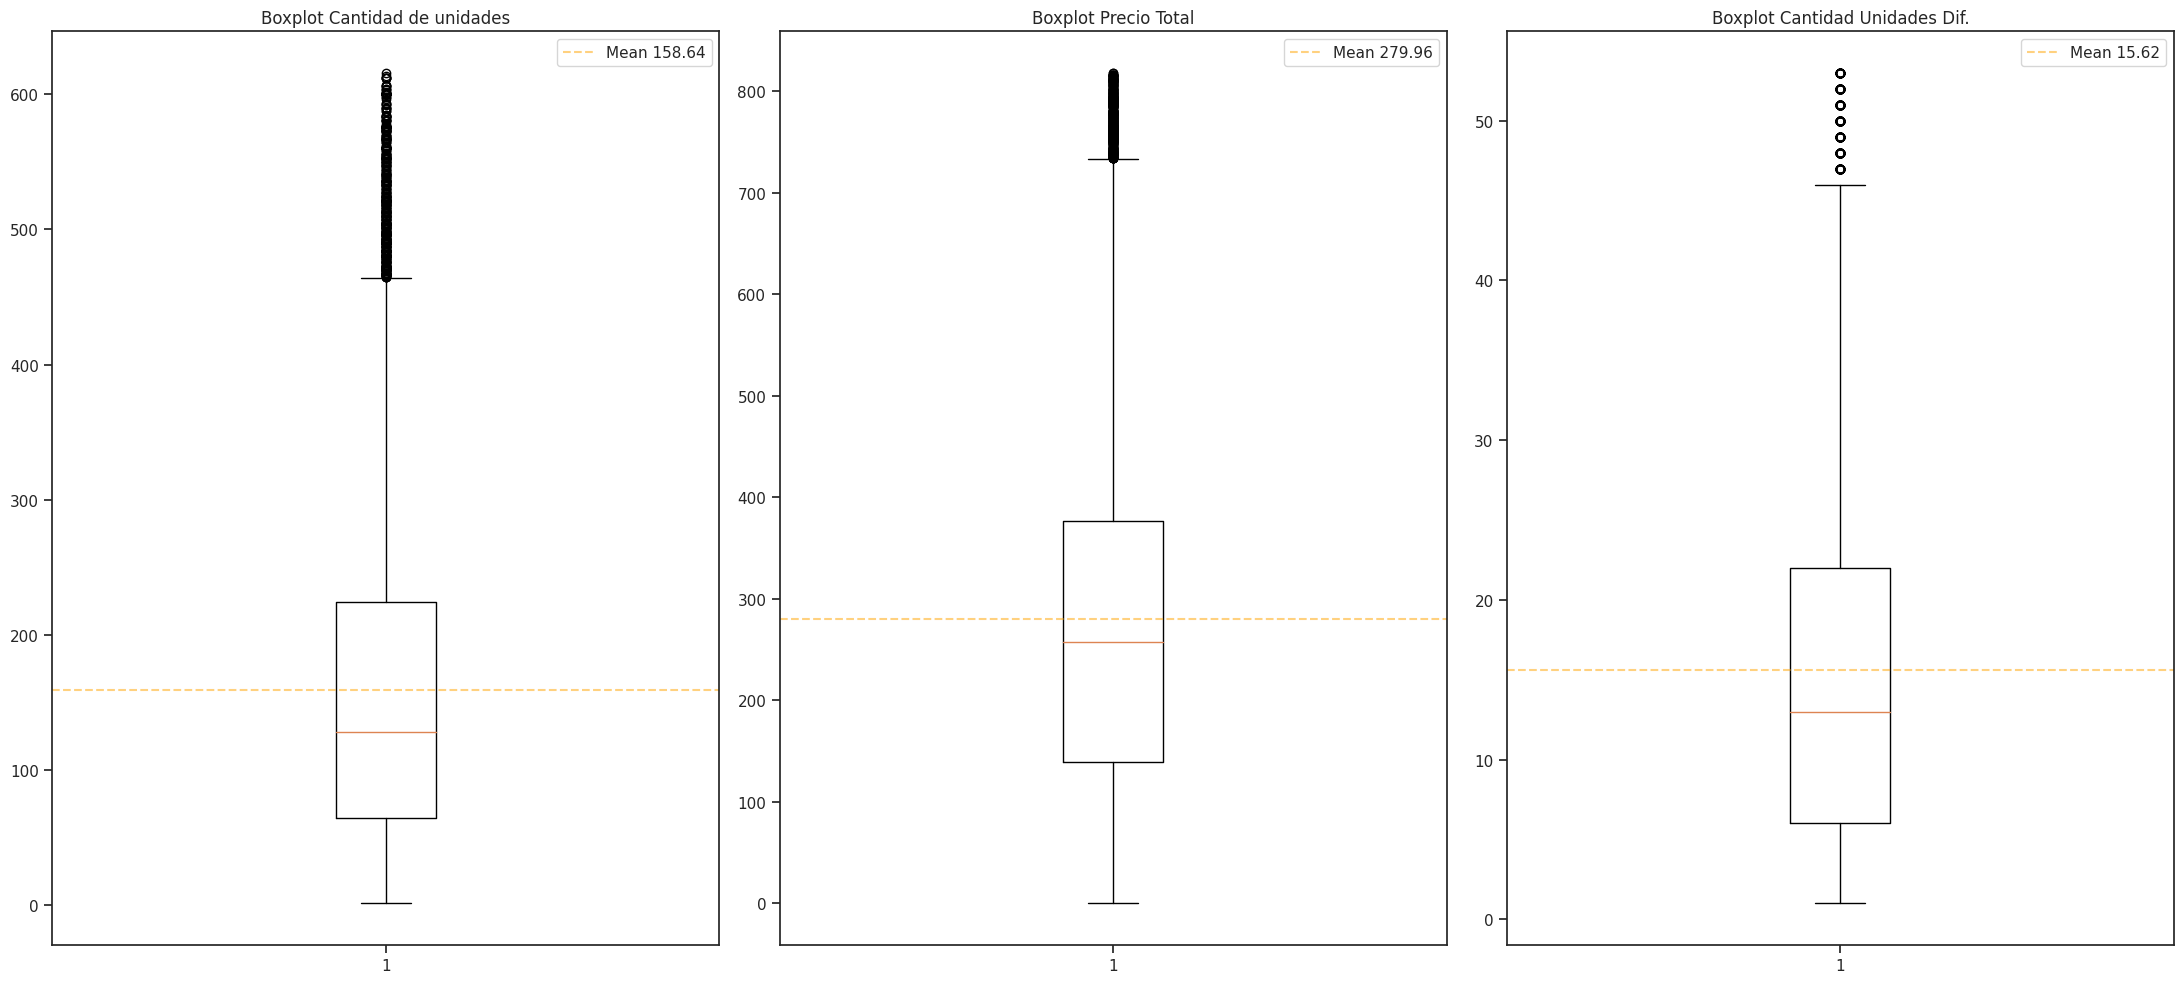

In [11]:
q_clean = df_clean["quantity"]
p_total_clean = df_clean["price_total"]
dif_units_clean = df_clean["different_units"]

# Visualizamos
sns.set_theme(style='ticks', palette='deep')
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(22, 10))

# Boxplots
axs[0].boxplot(q_clean)
axs[0].set_title("Boxplot Cantidad de unidades")
axs[0].axhline(q_clean.mean(), linestyle="dashed", color="orange",
               alpha=0.5, label=f"Mean {round(q_clean.mean(),2)}")
axs[0].legend()


axs[1].boxplot(p_total_clean)
axs[1].set_title("Boxplot Precio Total")
axs[1].axhline(p_total_clean.mean(), linestyle="dashed", color="orange",
               alpha=0.5, label=f"Mean {round(p_total_clean.mean(),2)}")
axs[1].legend()

axs[2].boxplot(dif_units_clean)
axs[2].set_title("Boxplot Cantidad Unidades Dif.")
axs[2].axhline(dif_units_clean.mean(), linestyle="dashed", color="orange",
               alpha=0.5, label=f"Mean {round(dif_units_clean.mean(),2)}")
axs[2].legend()

plt.tight_layout()
plt.legend()
plt.show()

Ahora analizaremos correlaciones

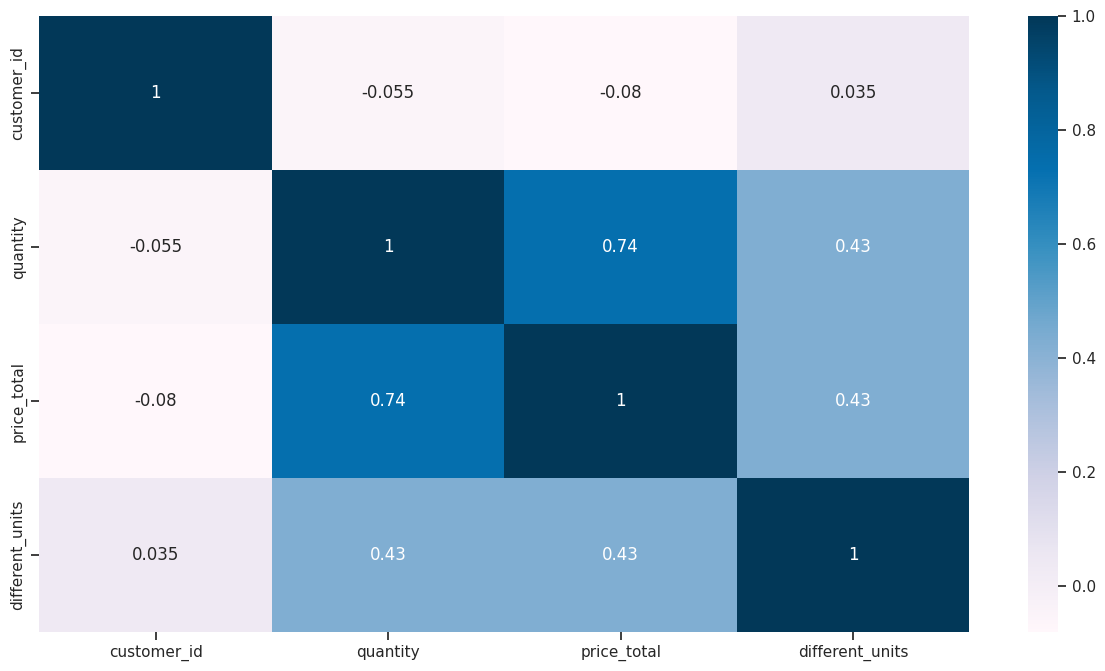

In [12]:
num_cols = df_clean[["quantity", "price_total", "different_units"]]
# Visualizamos
plt.figure(figsize=(15, 8))
sns.heatmap(df_clean.corr(numeric_only=True), annot=True, cmap=plt.cm.PuBu)
plt.show()

Podemos apreciar que la correlación positiva más fuerte es de price total con la cantidad de productos comprados, en cambio el resto de cruces no presenta correlaciones fuertes más alla de un 0.50. A pesar de que se ve una correlación negativa y casi nula con el Customer ID, tal véz en otro contexto de ejercicios el cliente si tenga comportamientos diferentes con respecto a precios, cantidaddes y productos diferentes.

#**2.Generar variables para la segmentación. Notar que la granularidad de la data es por boleta y se necesita segmentar clientes, por lo que es necesario generar variables a nivel de clientes. Se propone generar al menos RFM (Recencia,frecuencia y monto).**

Para generar RFM, primero agruparemos por cliente y asignaremos operaciones de MAX a la fecha para Recencia, de Count para Frecuencia y de SUM para Monto.

In [13]:
# Definimos las operaciones a realizar por cada columna para obtener RFM
operaciones = {
    # Calcula la recencia para cada clientes, usando la fecha maxima de la columna como MAX (actual), ya que la data no es reciente.
    "ticket_date": lambda x: (x.max() - x).dt.days.max(),
    "ticket_id": 'count',
    "price_total": 'sum'
}

# Primero creamos un DF con las caracteristicas para aplicar RFM
by_customer = df_clean.groupby("customer_id").agg(operaciones)
new_names = {"ticket_date": 'recency', "ticket_id": 'frequency',
             "price_total": 'monetary'}  # Diccionario para remplazar los nombres
# Renombramos las columnas para hacerlo más intuitivo
by_customer.rename(columns=new_names, inplace=True)
by_customer.head(10)

,recency,frequency,monetary
customer_id,,,
12347,365,6,3015.68
12348,243,3,904.44
12350,0,1,334.40
12352,260,7,1665.74
12353,0,1,89.00
12355,0,1,459.40
12356,223,2,539.81
12358,149,2,1168.06
12359,0,1,547.50


**Normalizacion de variables**

In [14]:
# Utilizamos standarscaler para la transformacion y normalizacion de la data.
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(by_customer))
X.columns = by_customer.columns
X.index = by_customer.index
X

,recency,frequency,monetary
customer_id,,,
12347,1.880265,0.345213,1.041470
12348,0.937663,-0.131358,-0.089414
12350,-0.939814,-0.449073,-0.394756
12352,1.069009,0.504071,0.318375
12353,-0.939814,-0.449073,-0.526204
...,...,...,...
18280,-0.939814,-0.449073,-0.477139
18281,-0.939814,-0.449073,-0.530586
18282,-0.020391,-0.290215,-0.478505


# **3.Realizar un análisis exploratorio y las transformaciones necesarias a las nuevas variables.**

In [15]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4038.0,3.519281e-17,1.000124,-0.939814,-0.939814,-0.368072,0.912553,1.942075
frequency,4038.0,-3.343316e-17,1.000124,-0.449073,-0.449073,-0.290215,0.027499,29.098365
monetary,4038.0,2.463496e-17,1.000124,-0.573663,-0.433414,-0.283826,0.069197,29.570791


Al normalizar las variables, practicamente se igualan los valores, por lo tanto descriptivamente, puede que no se aprecien diferencias notables

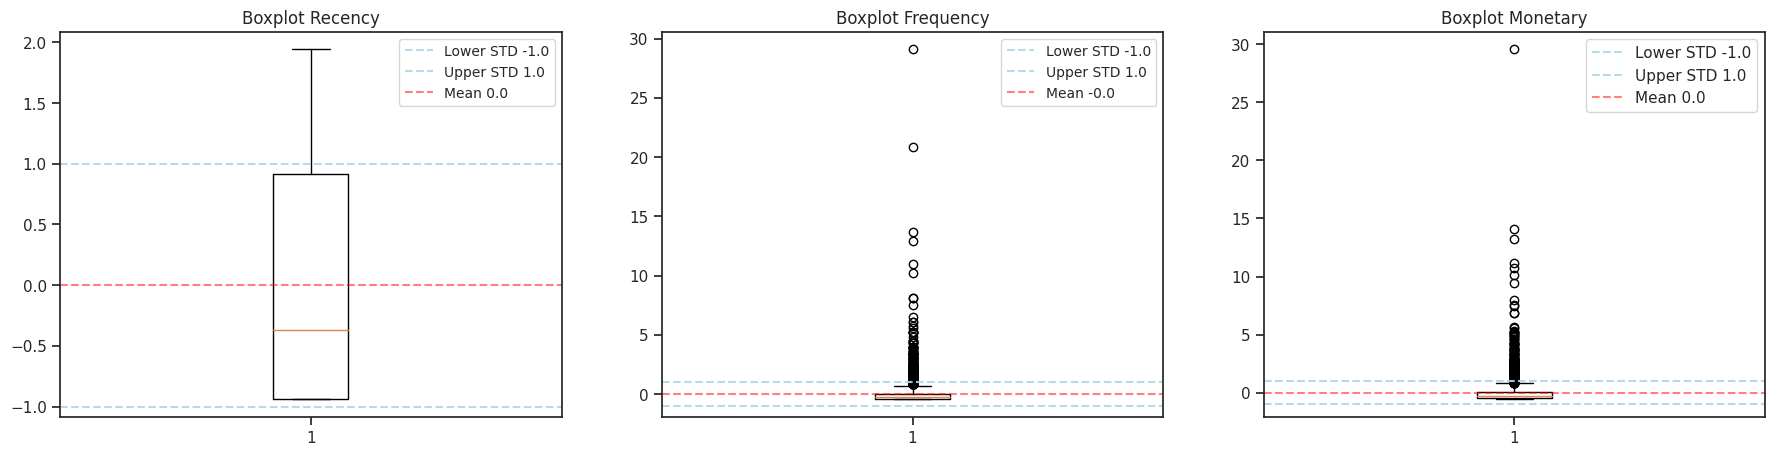

In [16]:
R = X["recency"]
F = X["frequency"]
M = X["monetary"]

sns.set_theme(style='ticks', palette='deep')
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(22, 5))

# Boxplots
axs[0].boxplot(R)
axs[0].set_title("Boxplot Recency")
axs[0].axhline(R.mean()-R.std(), linestyle="dashed", color="lightblue",
               alpha=0.9, label=f"Lower STD {round(R.mean()-R.std(),2)}")
axs[0].axhline(R.mean()+R.std(), linestyle="dashed", color="lightblue",
               alpha=0.9, label=f"Upper STD {round(R.mean()+R.std(),2)}")
axs[0].axhline(R.mean(), linestyle="dashed", color="red",
               alpha=0.5, label=f"Mean {round(R.mean(),2)}")
axs[0].legend(fontsize="small")

axs[1].boxplot(F)
axs[1].set_title("Boxplot Frequency")
axs[1].axhline(F.mean()-F.std(), linestyle="dashed", color="lightblue",
               alpha=0.9, label=f"Lower STD {round(F.mean()-F.std(),2)}")
axs[1].axhline(F.mean()+F.std(), linestyle="dashed", color="lightblue",
               alpha=0.9, label=f"Upper STD {round(F.mean()+F.std(),2)}")
axs[1].axhline(F.mean(), linestyle="dashed", color="red",
               alpha=0.5, label=f"Mean {round(F.mean(),2)}")
axs[1].legend(fontsize="small")

axs[2].boxplot(M)
axs[2].set_title("Boxplot Monetary")
axs[2].axhline(M.mean()-M.std(), linestyle="dashed", color="lightblue",
               alpha=0.9, label=f"Lower STD {round(M.mean()-M.std(),2)}")
axs[2].axhline(M.mean()+M.std(), linestyle="dashed", color="lightblue",
               alpha=0.9, label=f"Upper STD {round(M.mean()+M.std(),2)}")
axs[2].axhline(M.mean(), linestyle="dashed", color="red",
               alpha=0.5, label=f"Mean {round(M.mean(),2)}")
axs[2].legend()

plt.legend()
plt.show()

A pesar de ver "outliers" en las columnas frequency y monetary value en la data, por el contexto del ejercicio y la agrupacion por clientes, no podemos eliminar tales registros, ya que representan clientes con comportamientos de compra reales. Además, podemos usar algoritmos que funcionan de mejor manera frente a outliers como Fuzzy Cmeans, por lo que con la primera limpieza que se realizó más arriba, deberia ser suficiente.

# **4.Aplicar al menos 2 algoritmos de clustering. Buscar el número indicado de clusters que pueden tener y visualizar los cluster resultantes de los algoritmos.  y 5.Evaluar la calidad de los clustering de forma numérica y realizar una explicación de cada segmento asignándoles un nombre descriptivo.**

Primero usaremos el algoritmo Kmeans.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

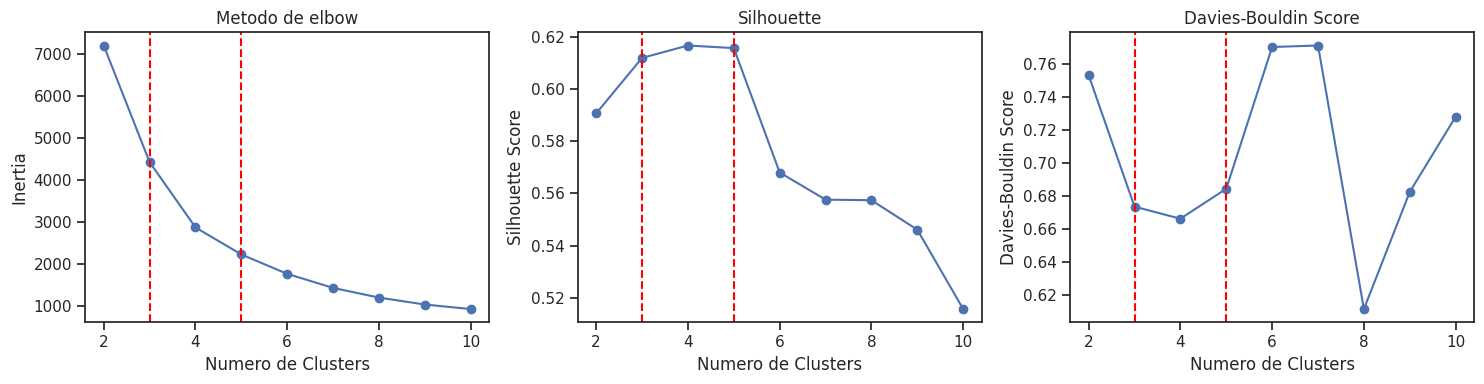

In [17]:
inertia, silhouette, davies = [], [], []
# Creamos un ciclo for que recorra el rango y nos almacene las metricas de desempeño por cada valor.
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=11238).fit(X)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X, kmeans.labels_))
    davies.append(davies_bouldin_score(X, kmeans.labels_))

# Visualizamos
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(range(2, 11), inertia, '-o')
plt.axvline(3, color="red", ls='--')
plt.axvline(5, color="red", ls='--')
plt.xlabel("Numero de Clusters")
plt.ylabel("Inertia")
plt.title("Metodo de elbow")

plt.subplot(1, 3, 2)
plt.plot(range(2, 11), silhouette, '-o')
plt.axvline(5, color="red", ls='--')
plt.axvline(3, color="red", ls='--')
plt.xlabel("Numero de Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette")

plt.subplot(1, 3, 3)
plt.plot(range(2, 11), davies, '-o')
plt.axvline(5, color="red", ls='--')
plt.axvline(3, color="red", ls='--')
plt.xlabel("Numero de Clusters")
plt.ylabel("Davies-Bouldin Score")
plt.title("Davies-Bouldin Score")
plt.tight_layout()
plt.show()

Elbow = El codo se genera dentro del rango entre 3-5 clusters, en donde la minimizacion de la inercia desciende 3000 desde el cluster 3, y en el 5, tenemos 2500 aprox.
Silhouette y Davies = Apreciando la grafica, podemos ver que entre el rango 3-5 los coeficientes presentan las mejores metricas de desempeño y tambien de forma más estable, siendo más estable en esa zona. (Considerando que debemos utilizar el numero de clusters en donde el Silouette sea alto y el Davies bajo)

***Para efectos de continuar, aplicaremos con el valor intermedio del rango, el cual será 4 Clusters.***

In [18]:
# Creamos el algoritmo en base al numero de clusters a testear
kmeans_opt = KMeans(n_clusters=4, random_state=11238).fit(X)
X["cluster"] = kmeans_opt.labels_  # Se guarda el resultado en una nueva columna

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [19]:
# Podemos hacer una pequeña revision de resultados
X.groupby(["cluster"]).mean()

,recency,frequency,monetary
cluster,,,
0,1.892284,13.159694,12.127107
1,-0.755075,-0.353305,-0.347989
2,0.995520,0.159376,0.132993
3,1.618047,2.179735,2.329159


Cluster 0 = Poca recencia, alta frecuencia y un monetary value alto.
Cluster 1 = Cliente que compró reciente, en poca frecuencia y con un valor de compra bajo
Cluster 2 = Poca recencia, poca frecuencia y un valor monetario no precisamente alto.
Cluster 3 = Poca recencia, mejor frecuencia que cluster 1 y 2 y un buen monetary value.

Podriamos deducir que el Cluster 0, al presentar la frecuencia más alta y el valor monetario más alto, son los "mejores clientes", a pesar de que no tengan un valor de recencia bajo. El objetivo con esos clientes sería poder fidelizarlos

**Ahora debemos hacer una reduccion de dimensionalidad para poder graficar en un scatter 2D**

In [20]:
pca = PCA(n_components=2)
df_to_plot = pd.DataFrame(pca.fit_transform(X))
df_to_plot["cluster"] = kmeans_opt.labels_
df_to_plot

,0,1,cluster
0,1.904055,-0.970553,2
1,0.500714,-0.970500,2
2,-1.093260,0.503995,1
3,1.168008,-0.635137,2
4,-1.168841,0.449588,1
...,...,...,...
4033,-1.140629,0.469897,1
4034,-1.171360,0.447775,1
4035,-0.583151,-0.111941,1
4036,1.491396,-0.876228,2


(-5.0, 10.0)

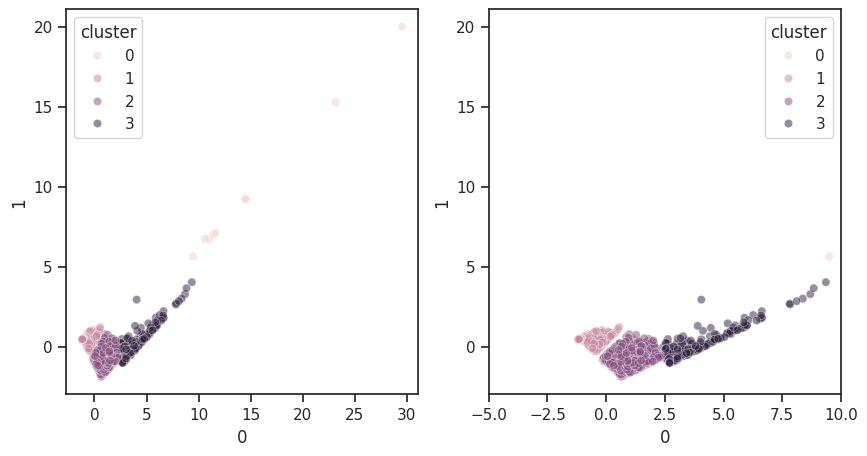

In [21]:
# Graficar los clusters en el espacio reducido por PCA
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_to_plot, x=0, y=1, hue="cluster", alpha=0.5)
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_to_plot, x=0, y=1, hue="cluster", alpha=0.5)
plt.xlim(-5, 10)

**Aplicaremos evaluaciones cuantitativas al modelo**

In [22]:
# Calcular el coeficiente de Silhouette
silhouette_coefficient = silhouette_score(X, kmeans_opt.labels_)
# Calcular el índice de Davies-Bouldin
davies_bouldin_index = davies_bouldin_score(X, kmeans_opt.labels_)

print("Coeficiente de Silhouette:", silhouette_coefficient)
print("Índice de Davies-Bouldin:", davies_bouldin_index)

Coeficiente de Silhouette: 0.67350864848834
Índice de Davies-Bouldin: 0.6286213235852414


**La grafica 2 nos ayuda a poder identificar de mejor manera los clusters, quiza no de manera tan precisa, ya que la distancia entre ellos al parecer no es mucha, sin embargo, la cohesion o distancia entre los puntos que los componen si pareciera ser buena. El Coeficiente de Silouette cercano a 0.7 pareciera validar esta afirmación, sin embargo el Davies, debiese ser mucho más bajo.**

In [23]:
X

,recency,frequency,monetary,cluster
customer_id,,,,
12347,1.880265,0.345213,1.041470,2
12348,0.937663,-0.131358,-0.089414,2
12350,-0.939814,-0.449073,-0.394756,1
12352,1.069009,0.504071,0.318375,2
12353,-0.939814,-0.449073,-0.526204,1
...,...,...,...,...
18280,-0.939814,-0.449073,-0.477139,1
18281,-0.939814,-0.449073,-0.530586,1
18282,-0.020391,-0.290215,-0.478505,1


In [24]:
# Convertir la columna "cluster" en un tipo de datos categórico
X['cluster'] = X['cluster'].astype(str)

# Definir un mapa de colores para asignar a cada cluster
# Ajusta según los nombres de tus clusters y los colores deseados
color_map = {'0': 'red', '1': 'blue', '2': 'green', '3': 'orange'}

# Crear el gráfico de dispersión 3D con el mapa de colores
fig = px.scatter_3d(X, x="recency", y="frequency", z="monetary",
                    color="cluster", color_discrete_map=color_map, opacity=0.3)

# Configurar el tamaño de los marcadores
fig.update_traces(marker_size=5)

# Mostrar el gráfico
fig.show()

En este grafico 3D podemos ver de mejor manera el comportamiento de los clusters con respecto a los features. El Cluster 1, los cuales tienen poca frecuencia de compra y poca recencia, además de un valor monetario de compra bajo, podrian catalogarse como compradores ocasionales. Por el contrario, los del cluster 0, que son los puntos que se escapan de las tendencias, son los clientes que tienen mejor frecuencia, recencia y compras de mayor tamaño. Cluster 2 y 3 deberian aplicarseles estrategias de marketing para poder fidelizarlos al negocio.

**Ahora aplicaremos el algoritmo de Fuzzy C-Means**

In [25]:
X

,recency,frequency,monetary,cluster
customer_id,,,,
12347,1.880265,0.345213,1.041470,2
12348,0.937663,-0.131358,-0.089414,2
12350,-0.939814,-0.449073,-0.394756,1
12352,1.069009,0.504071,0.318375,2
12353,-0.939814,-0.449073,-0.526204,1
...,...,...,...,...
18280,-0.939814,-0.449073,-0.477139,1
18281,-0.939814,-0.449073,-0.530586,1
18282,-0.020391,-0.290215,-0.478505,1


<ipython-input-71-0a0cc679e16c>:34: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



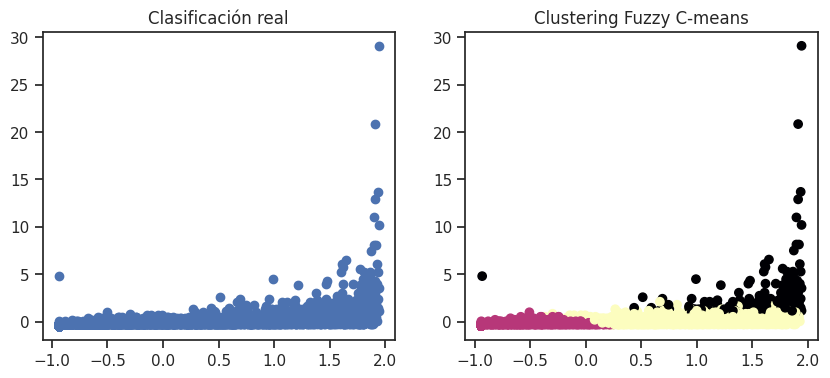


Valor óptimo de m: 1.7000000000000006



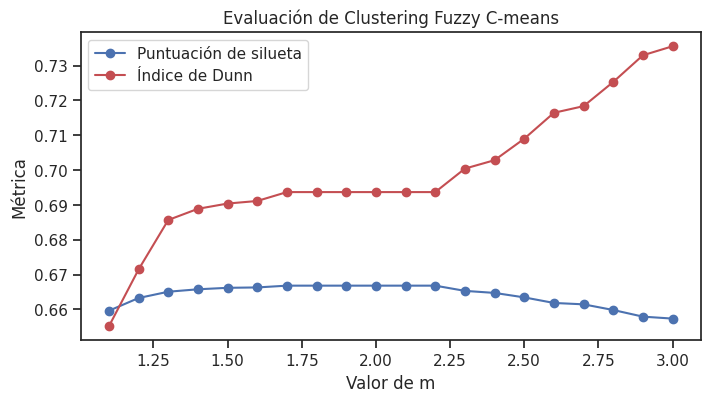


Puntuación de silueta para m óptimo: 0.666812658859519
Índice de Davies-Bouldin para m óptimo: 0.6936883821888508


In [ ]:
X = X.astype(float)

# Primero debemos definir los valores de m, para el parámetro fuzziness
m_values = np.arange(1.1, 3.1, 0.1)

# Creamos las listas de las métricas de evaluación cuantitativa para que se almacenen los resultados
sil_score_fuzzy = []
davies_score_fuzzy = []

# Realizamos el clustering con los valores de m y se calculan sus métricas de desempeño
for m in m_values:
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X.T, 3, m, error=0.005, maxiter=1000)  # iterará máximo 1000 veces
    labels = np.argmax(u, axis=0)

    # Se calcula el coeficiente de silueta
    sil_score = silhouette_score(X, labels)
    sil_score_fuzzy.append(sil_score)

    # Calculamos el índice de Dunn
    dunn_index = davies_bouldin_score(X, labels)
    davies_score_fuzzy.append(dunn_index)

# Encontrar el valor óptimo de m basado en la puntuación de silueta
optimal_index = np.argmax(sil_score_fuzzy)
optimal_m = m_values[optimal_index]

# Realizamos el clustering a partir del valor óptimo de M
optimal_cntr, optimal_u, optimal_u0, optimal_d, optimal_jm, optimal_p, optimal_fpc = fuzz.cluster.cmeans(
    X.T, 3, optimal_m, error=0.005, maxiter=1000)
optimal_labels = np.argmax(optimal_u, axis=0)

# Graficar los resultados en 2D
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], cmap='magma')
plt.title('Clasificación real')
plt.subplot(122)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=optimal_labels, cmap='magma')
plt.title('Clustering Fuzzy C-means')
plt.show()
print("")

# Imprimir el valor óptimo de m
print(f"Valor óptimo de m: {optimal_m}")
print("")

# Graficar la puntuación de silueta y el índice de Dunn
plt.figure(figsize=(8, 4))
plt.plot(m_values, sil_score_fuzzy, 'bo-', label='Puntuación de silueta')
plt.plot(m_values, davies_score_fuzzy, 'ro-', label='Índice de Dunn')
plt.xlabel('Valor de m')
plt.ylabel('Métrica')
plt.title('Evaluación de Clustering Fuzzy C-means')
plt.legend()
plt.show()

print("")
# Imprimir las métricas de evaluación correspondientes al valor óptimo de m
print(f"Puntuación de silueta para m óptimo: {sil_score_fuzzy[optimal_index]}")
print(
    f"Índice de Davies-Bouldin para m óptimo: {davies_score_fuzzy[optimal_index]}")

**Como podemos apreciar, las metricas de evaluación demuestran valores de rendimiento similares al algoritmo Kmeans, aunque la variabilidad de resultados es notablemente superior con valores de m cercanos a 1 por razones logicas. Sin embargo, basandonos en la grafica y un silouette cercano a 0.7, podriamos deducir que existe buena cohesion, más no separación entre clusters, pero siguen siendo reflejo de los mismos resultados del algoritmo anterior en cuanto a segmentación y comportamiento de los clientes.**

**Sería relevante intentar con otros algoritmos o evaluar otras tecnicas de segmentación de clientes para ver como se comportan las metricas de evaluación y así poder concluir precisamente frente a cuantos tipos de clientes nos encontramos.**

Se podria continuar iterando sobre otros valores de K, sin embargo no se obtendrán mejores resultados de Silhouette ni Davies, basados en la grafica de evaluacion del principio.